# 2052 hot ADC channel

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import mapping
import argparse
from pyDepfetReader import FileReader
from epics_utils import get_pv
from glob import glob
import plots

max_row = 768
max_col = 256


In [5]:
dhe = 'H2052'

expnr = 12
#runnr=1568
#runnr=1580

runs = [1649,1657,1717,1761,1768,1799,1800]
#runs = [1717,1761,1768,1799,1800]

do_masking = False

In [6]:

device = get_pv("PXD:B:config-"+dhe,"device_config:VALUE:set").get()
module = get_pv("PXD:B:config-"+dhe,"device_module:VALUE:set").get()
module_type = get_pv("PXD:B:config-"+dhe,"module_type:VALUE:set").get()

reader = FileReader(-1,0)
reader.set_debug_output(False)
reader.return_time = True

file_path="/data/commissioning/runs/all/EXP"+format(expnr,"04")

for runnr in runs:

    file_names=glob(os.path.join(file_path,"Run"+format(runnr,"04")+"-0.dat"))
    print file_names

    if do_masking and os.path.isfile('/data/commissioning/runs/all/EXP%04i/Run%04i_%s_occ_mask.npy'%(expnr,runnr,dhe)):
        maskfile = np.load('/data/commissioning/runs/all/EXP%04i/Run%04i_%s_occ_mask.npy'%(expnr,runnr,dhe))
        mask = [ i[1]+i[0]/1000. for i in np.transpose(np.where(maskfile>0))]
        print len(mask),'pixels in mask file.'
    else: 
        mask=[]
    #print mask
    
    hitmap = np.zeros((max_row, max_col), dtype=np.int16)

    for f in file_names:
        reader.open(os.path.join(file_path, f))

        for idx,event in enumerate(reader):
            if idx>20000: break
            if idx%10000 ==0: print 'frames %i'%idx

            for idhe, data,raw,dac in event:
                if idhe != dhe: continue

                data_m = [i for i in data if i[0]+i[1]/1000. not in mask]

                for hit in data_m:
                    #if hit[1]>128*5: continue
                    hitmap[hit[1]][hit[0]] += 1

    np.save('hitmaps/%s_exp%04irun%04i_hitmap.npy'%(dhe,expnr,runnr), hitmap)

print 'done'

['/data/commissioning/runs/all/EXP0012/Run1649-0.dat']
frames 0
frames 10000
frames 20000
['/data/commissioning/runs/all/EXP0012/Run1657-0.dat']
frames 0
frames 10000
frames 20000
['/data/commissioning/runs/all/EXP0012/Run1717-0.dat']
frames 0
frames 10000
frames 20000
['/data/commissioning/runs/all/EXP0012/Run1761-0.dat']
frames 0
frames 10000
frames 20000
['/data/commissioning/runs/all/EXP0012/Run1768-0.dat']
frames 0
frames 10000
frames 20000
['/data/commissioning/runs/all/EXP0012/Run1799-0.dat']
frames 0
frames 10000
frames 20000
['/data/commissioning/runs/all/EXP0012/Run1800-0.dat']
frames 0
frames 10000
frames 20000
done


(768, 256)
run1649 : (array([354]),)
(768, 256)
run1657 : (array([354]),)
(768, 256)
run1717 : (array([353, 400, 439, 465]),)
(768, 256)
run1761 : (array([314, 359, 390]),)
(768, 256)
run1768 : (array([314, 353, 359, 390, 465]),)
(768, 256)
run1799 : (array([314, 359, 400, 423, 465, 481, 488]),)
(768, 256)
run1800 : (array([314, 348, 353, 400]),)
12 [314, 348, 353, 354, 359, 390, 400, 423, 439, 465, 481, 488]


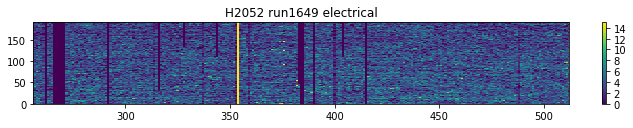

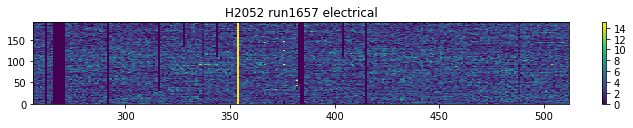

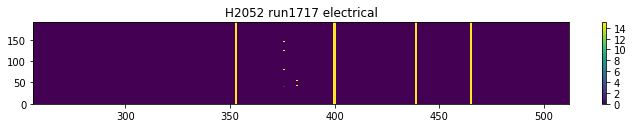

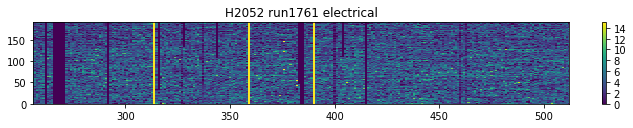

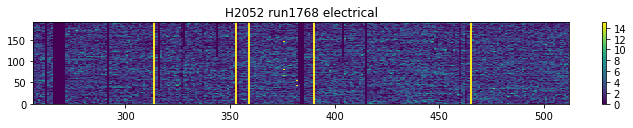

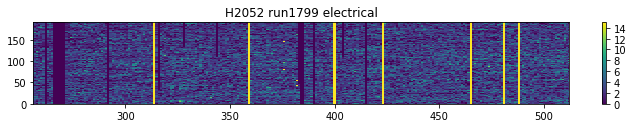

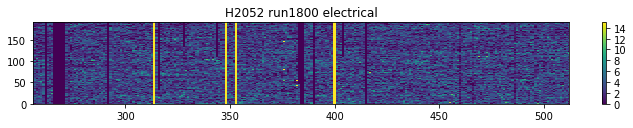

In [49]:
#hitmap = np.load('%s_exp%04irun%04i_hitmap.npy'%(dhe,expnr,runnr))

#fig, ax = plt.subplots(figsize=(3,6))
#plots.plot_occupancyXY(hitmap, ax,device=device, module=module, module_type=module_type, asicpair=0,
#        title="%s - %s"%(dhe, module),vmin=0,vmax=1.1*np.percentile(hitmap,95),colorbar=True)
#ax.set_xlim(64,128)

hotadcs=[]
def plot_asic(runnr, axes=None):
    hitmap = np.load('hitmaps/%s_exp%04irun%04i_hitmap.npy'%(dhe,expnr,runnr))

    if axes is None:
        fig, axes = plt.subplots(figsize=(12,1.5))
        
    matrix_dcd = mapping.matrixToDcd(hitmap)
    print 'run%s :'%runnr, np.where(np.mean(matrix_dcd, axis=0)>13*192)
    for i in np.where(np.mean(matrix_dcd, axis=0)>13*192)[0]:
        hotadcs.append(i) 

    im = axes.imshow(matrix_dcd, interpolation="none",origin="lower", aspect="auto", vmin=0,vmax=15)
    cbar = plt.colorbar(im)

    axes.set_title('%s run%s electrical'%(dhe, runnr))
    axes.set_xlim(256,512)
    #axes.set_xlim(300,350)
    
#fig, axes = plt.subplots(len(runs),1,figsize=(12,2*len(runs)),sharex=True,tight_layout=True)
for i, runnr in enumerate(runs):
    plot_asic(runnr=runnr)


hotadcs = sorted(set(hotadcs))
print len(hotadcs), hotadcs

# zs_analysis: get hot pixels

ASIC 1:  3
ASIC 2:  206
ASIC 3:  3
ASIC 4:  2
noisy drain (array([486]),)
noisy gate (array([], dtype=int64),)


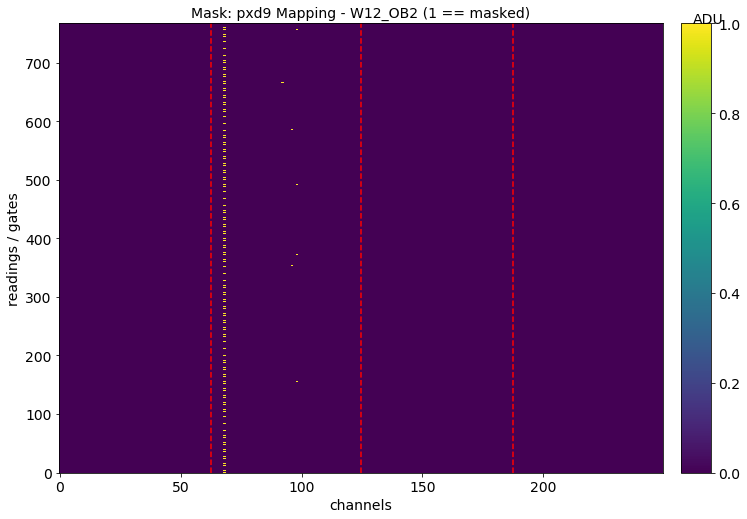

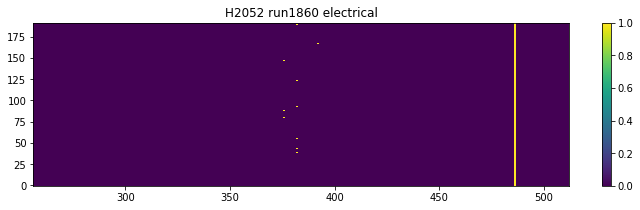

In [184]:
# Noisy pixels

from zs_data_utils import get_hot_pixels
import plots
import glob

gcr_path = '/data/commissioning/runs/all/EXP0012/'
#gcr_runs = [978]
#gcr_runs = [1001]
#gcr_runs = [1580]
gcr_runs = [1953]


dhe = 'H2052'
asicpair = 0
threshold = 0.001

device = get_pv("PXD:B:config-"+dhe,"device_config:VALUE:set").get()
module = get_pv("PXD:B:config-"+dhe,"device_module:VALUE:set").get()
module_type = get_pv("PXD:B:config-"+dhe,"module_type:VALUE:set").get()

for run in gcr_runs:
    rundata = os.path.join(gcr_path, 'Run%04d-0.dat'%run)
    #rundata = glob.glob(os.path.join(gcr_path, 'Run%04d-*.dat'%run))
    
    if not os.path.isfile(rundata):
        print rundata, 'not exist.'
        continue
    
    pixel_masks_merged, hits_per_pixel_unmasked, events_per_pixel_masked = get_hot_pixels(rundata, dhe, asicpair, threshold)
    
    #print np.transpose(np.where(hits_per_pixel_unmasked>0))
    mask = np.ma.array(np.zeros((768, 256)), mask=pixel_masks_merged[:, :, 0], fill_value=255, dtype=np.uint8).filled()
    
    fig = plots.plot_mask(mask=mask, device=device, module=module, module_type=module_type, asicpair=asicpair)
    #fig.axes[0].set_ylim(600,650)
    
    print 'ASIC 1: ', (len(np.where(mask[:,0:64]>0)[0]))
    print 'ASIC 2: ', (len(np.where(mask[:,64:128]>0)[0]))
    print 'ASIC 3: ', (len(np.where(mask[:,128:192]>0)[0]))
    print 'ASIC 4: ', (len(np.where(mask[:,192:256]>0)[0]))
    
    matrix_dcd = mapping.matrixToDcd(mask).astype(dtype=np.bool)
    print 'noisy drain',np.where(np.sum(matrix_dcd,axis=0)>50)
    print 'noisy gate',np.where(np.sum(matrix_dcd,axis=1)>200)

    figs, axes = plt.subplots(figsize=(12,3))
    im = axes.imshow(matrix_dcd, interpolation="none",origin="lower", aspect="auto", vmin=0,vmax=1)
    cbar = plt.colorbar(im)

    axes.set_title('%s run%s electrical'%(dhe, runnr))
    axes.set_xlim(256,512)

# Create new mask

Current in use H2052 W12_OB2 has masked 456
ASIC 1:  6
ASIC 2:  412
ASIC 3:  16
ASIC 4:  22
Newly prepared  H2052 W12_OB2 has masked 2760
ASIC 1:  6
ASIC 2:  2716
ASIC 3:  16
ASIC 4:  22


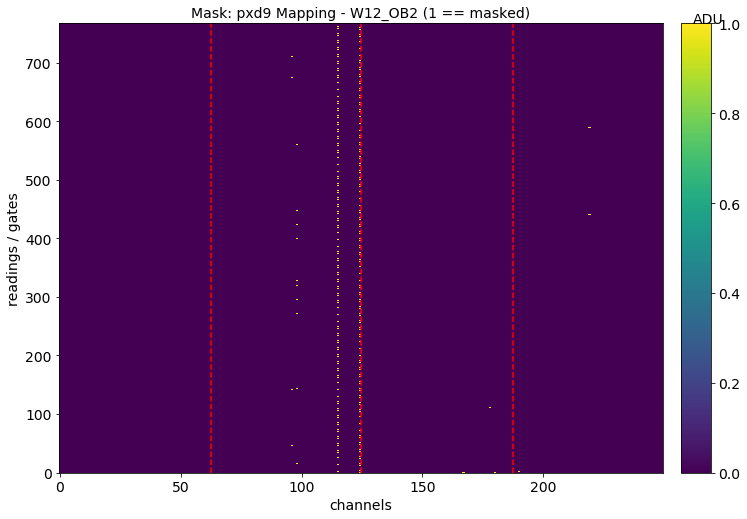

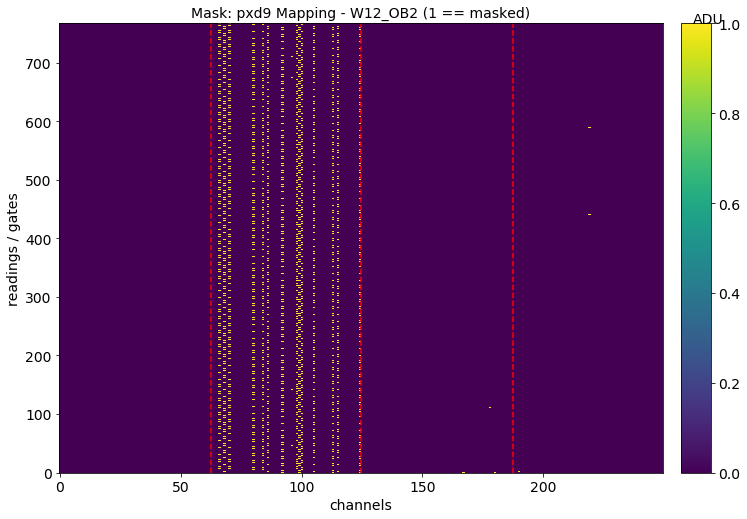

In [36]:
import plots

## current masks
dhe = 'H2052'
asicpair = 0

device = get_pv("PXD:B:config-"+dhe,"device_config:VALUE:set").get()
module = get_pv("PXD:B:config-"+dhe,"device_module:VALUE:set").get()
module_type = get_pv("PXD:B:config-"+dhe,"module_type:VALUE:set").get()

curr_mask = np.load("/data/commissioning/ped_mask/%s/manual_noisemask.npy"%module)

print 'Current in use', dhe, module,'has masked',len(np.where(curr_mask>0)[0])
print 'ASIC 1: ', (len(np.where(curr_mask[:,0:64]>0)[0]))
print 'ASIC 2: ', (len(np.where(curr_mask[:,64:128]>0)[0]))
print 'ASIC 3: ', (len(np.where(curr_mask[:,128:192]>0)[0]))
print 'ASIC 4: ', (len(np.where(curr_mask[:,192:256]>0)[0]))

new_mask = curr_mask.copy()

#2052 drainlines
matrix_dcd = mapping.matrixToDcd(new_mask)
#matrix_dcd[:,262] = 1
#matrix_dcd[:,292] = 1
##matrix_dcd[:,354] = 1
##matrix_dcd[:,486] = 1
##matrix_dcd[:,488] = 1

for i in [314, 348, 353, 354, 359, 390, 400, 423, 439, 465, 481, 488]:
    matrix_dcd[:,i] = 1

new_mask = mapping.dcdToMatrix(matrix_dcd)

print 'Newly prepared ', dhe, module,'has masked',len(np.where(new_mask>0)[0])
print 'ASIC 1: ', (len(np.where(new_mask[:,0:64]>0)[0]))
print 'ASIC 2: ', (len(np.where(new_mask[:,64:128]>0)[0]))
print 'ASIC 3: ', (len(np.where(new_mask[:,128:192]>0)[0]))
print 'ASIC 4: ', (len(np.where(new_mask[:,192:256]>0)[0]))

fig1 = plots.plot_mask(mask=curr_mask, device=device, module=module, module_type=module_type, asicpair=asicpair)
fig2 = plots.plot_mask(mask=new_mask, device=device, module=module, module_type=module_type, asicpair=asicpair)

np.save('mask%s.npy'%module, new_mask)
fig2.savefig('mask%s.pdf'%module)

# Draw Pedestals

run 1649 /data/commissioning/runs/all/EXP0012/pedestal/run1649/H2052/analysis.npy


/home/b2pxd/lab_framework/lib/plots.py:472: RuntimeWarning: overflow encountered in ubyte_scalars
  axes.text( (min_pedestal+max_pedestal)/2, max(axes.get_ylim())*0.95, "spread=%.0f"%(max_pedestal-min_pedestal+1), color='red', horizontalalignment="center", fontsize=textsize)


run 1657 /data/commissioning/runs/all/EXP0012/pedestal/run1657/H2052/analysis.npy
run 1717 /data/commissioning/runs/all/EXP0012/pedestal/run1717/H2052/analysis.npy
run 1761 /data/commissioning/runs/all/EXP0012/pedestal/run1761/H2052/analysis.npy
/data/commissioning/runs/all/EXP0012/pedestal/run1768/H2052/analysis.npy not exist
/data/commissioning/runs/all/EXP0012/pedestal/run1799/H2052/analysis.npy not exist
run 1800 /data/commissioning/runs/all/EXP0012/pedestal/run1800/H2052/analysis.npy


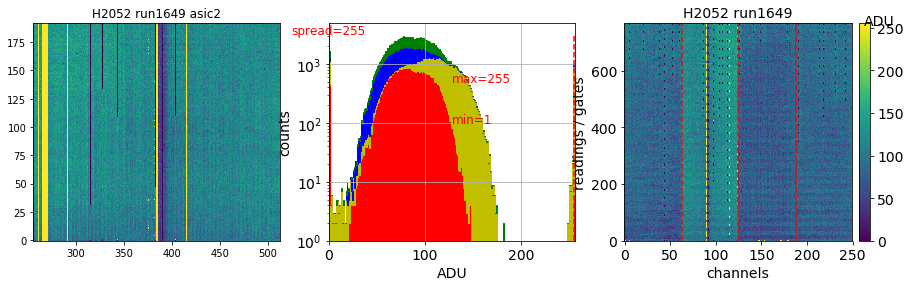

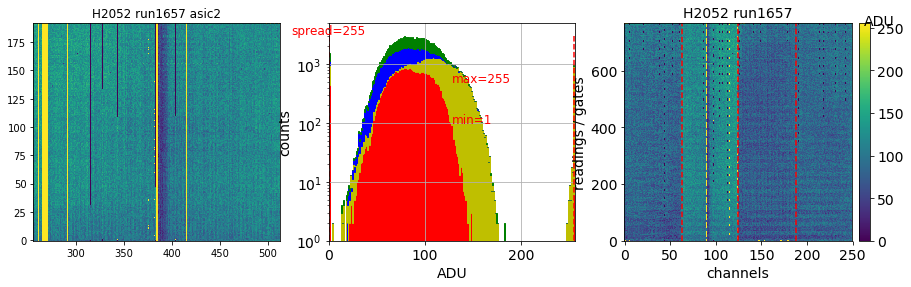

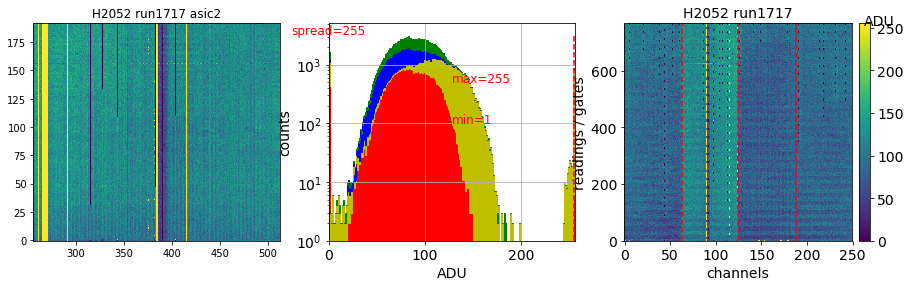

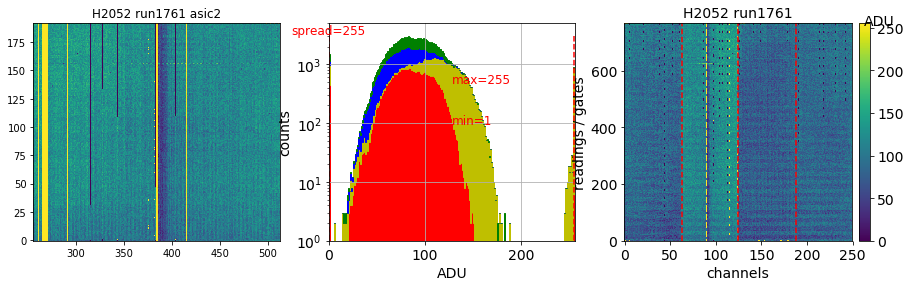

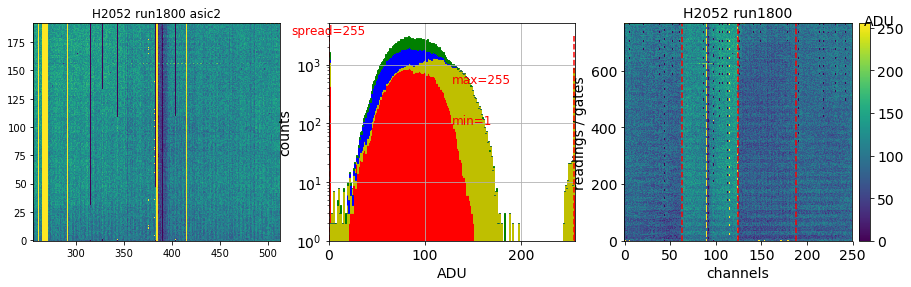

In [68]:
import naming_utils
import plots 


dhe = 'H2052'
path = '/data/commissioning/runs/all/EXP%04i/pedestal'%expnr

device = get_pv("PXD:B:config-"+dhe,"device_config:VALUE:set").get()
module_flavor = naming_utils.dhe_name_to_flavor(dhe)

for runnr in runs:

    f = os.path.join(path,'run%04i'%runnr,dhe,'analysis.npy')
    if not os.path.isfile(f):
        print f, 'not exist'
        continue
    else:
        print 'run',runnr, f
        
    peds = np.load(f, allow_pickle=True).item()
    peds = np.concatenate([peds['PXD:{}:D1:pedestal_data_512'.format(dhe)] 
                                ,peds['PXD:{}:D2:pedestal_data_512'.format(dhe)] 
                                ,peds['PXD:{}:D3:pedestal_data_512'.format(dhe)] 
                                ,peds['PXD:{}:D4:pedestal_data_512'.format(dhe)] 
                               ], axis=1)
 
    fig, axes = plt.subplots(1,3,figsize=(15,4))

    peds_e = mapping.matrixToDcd(peds)
    
    axes[0].imshow(peds_e, interpolation="none",origin="lower", aspect="auto")
    axes[0].set_xlim(256,512)
    axes[0].set_title('%s run%s asic2'%(dhe,runnr))

    mapper = mapping.mapper(module_type='pxd9', module_flavor=module_flavor, asicpair=0)    
    peds_m = mapper(peds)

    peds3d = peds.reshape((peds.shape[0], peds.shape[1], 1))
    plots.plot_adcraw_stacked(peds3d, axes[1], device=device, show_legend=False)
    
    plots.plot_occupancyXY(peds, axes[2], device=device, module_type=module_type, asicpair=0, title='%s run%s'%(dhe,runnr))

    #axes[1].imshow(peds_m, interpolation="none",origin="lower", aspect="auto")
    #axes[1].set_title('%s run%s'%(dhe,runnr))
    
    

selected 146 runs: [17, 338, 505, 797, 798, 799, 805, 808, 870, 875, 878, 949, 950, 978, 979, 981, 983, 985, 988, 990, 1000, 1001, 1020, 1029, 1036, 1039, 1041, 1042, 1043, 1044, 1091, 1093, 1094, 1095, 1097, 1149, 1150, 1151, 1154, 1155, 1188, 1190, 1191, 1192, 1194, 1198, 1200, 1292, 1296, 1329, 1331, 1333, 1397, 1398, 1399, 1401, 1404, 1406, 1408, 1409, 1410, 1413, 1416, 1418, 1422, 1428, 1433, 1436, 1439, 1442, 1444, 1454, 1455, 1458, 1463, 1472, 1473, 1474, 1475, 1476, 1480, 1482, 1536, 1541, 1542, 1545, 1546, 1548, 1549, 1557, 1558, 1561, 1563, 1569, 1579, 1580, 1582, 1583, 1585, 1590, 1641, 1646, 1649, 1652, 1657, 1659, 1708, 1709, 1711, 1715, 1717, 1719, 1722, 1724, 1729, 1731, 1741, 1742, 1746, 1750, 1753, 1754, 1756, 1760, 1761, 1763, 1766, 1771, 1773, 1775, 1780, 1781, 1783, 1788, 1790, 1794, 1796, 1797, 1800, 1806, 1808, 1809, 1812, 1816, 1859, 1860]
(768, 64)
(768, 64)
(768, 64)
(768, 64)


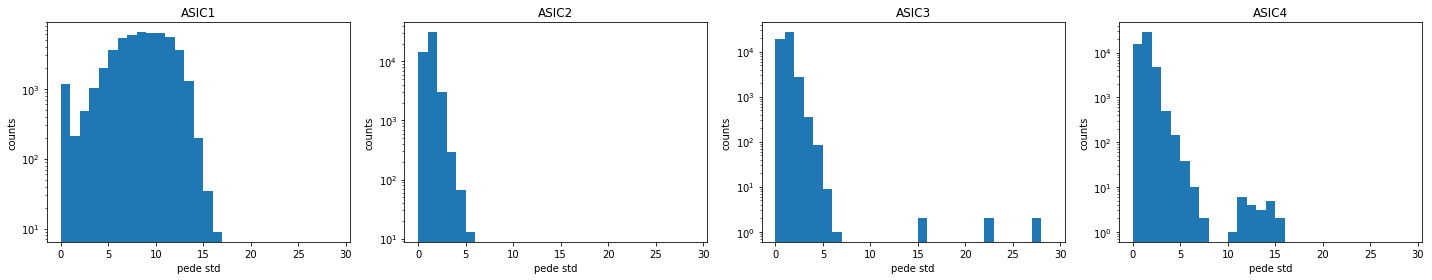

In [168]:
# std of each ASIC

selected_runs = []

dhe='H2051'
selected_all_runs = True
if selected_all_runs:
    path = '/data/commissioning/runs/all/EXP%04i/pedestal'%expnr
    for run in os.listdir(path):
        if os.path.isfile(os.path.join(path,run,dhe,'analysis.npy')):
            selected_runs.append(int(run[3:]))
else:
    for runnr in runs:
        f = os.path.join(path,'run%04i'%runnr,dhe,'analysis.npy')
        if not os.path.isfile(f):
            print f, 'not exist'
            continue
        else:
            selected_runs.append(runnr)
print 'selected',len(selected_runs),'runs:',selected_runs   
        
asic_peds={}
for i in range(1,5):
    asic_peds[i] = np.zeros((768,64,len(selected_runs)))
        
for idx, runnr in enumerate(selected_runs):
    f = os.path.join(path,'run%04i'%runnr,dhe,'analysis.npy')
    peds = np.load(f, allow_pickle=True).item()
    for i in range(1,5):
        asic_peds[i][:,:,idx] = peds['PXD:%s:D%s:pedestal_data_512'%(dhe,i)]
        #print idx,i, peds['PXD:%s:D%s:pedestal_data_512'%(dhe,i)], asic_peds[i]

fig, axes = plt.subplots(1,4,figsize=(20,4),tight_layout=True)
for i in range(1,5):
    print np.std(asic_peds[i],axis=2).shape
    axes[i-1].hist(np.std(asic_peds[i],axis=2).flatten(), bins=range(0,30))
    axes[i-1].set_xlabel('pede std')
    axes[i-1].set_ylabel('counts')
    axes[i-1].set_yscale('log')
    axes[i-1].set_title('ASIC%i'%i)

In [155]:
import naming_utils
import plots 


dhe = 'H2052'
path = '/data/commissioning/runs/all/EXP%04i/pedestal'%expnr

adcs=[314, 348, 353, 354, 359, 390, 400, 423, 439, 465, 481, 488]
adcs = [adc-2 for adc in adcs]
print 'adcs', adcs

peds_slice = {adc:np.zeros(192, dtype=np.int16) for adc in adcs}

device = get_pv("PXD:B:config-"+dhe,"device_config:VALUE:set").get()
module_flavor = naming_utils.dhe_name_to_flavor(dhe)

selected_runs = []
for runnr in runs:

    f = os.path.join(path,'run%04i'%runnr,dhe,'analysis.npy')
    if not os.path.isfile(f):
        print f, 'not exist'
        continue
    else:
        print 'run',runnr, f
        selected_runs.append(runnr)
        
    peds = np.load(f, allow_pickle=True).item()
    peds = np.concatenate([peds['PXD:{}:D1:pedestal_data_512'.format(dhe)] 
                                ,peds['PXD:{}:D2:pedestal_data_512'.format(dhe)] 
                                ,peds['PXD:{}:D3:pedestal_data_512'.format(dhe)] 
                                ,peds['PXD:{}:D4:pedestal_data_512'.format(dhe)] 
                               ], axis=1)
 
    peds_e = mapping.matrixToDcd(peds)
    
    for adc in adcs:
        #print peds_slice[adc].shape, peds_e[:,adc].shape
        peds_slice[adc] = np.hstack([peds_slice[adc], peds_e[:,adc]])
        
for adc in adcs:
    peds_slice[adc]=peds_slice[adc][192:].reshape((-1, 192))
    print adc, peds_slice[adc].shape

print 'selected runs: ', selected_runs

adcs [312, 346, 351, 352, 357, 388, 398, 421, 437, 463, 479, 486]
run 1649 /data/commissioning/runs/all/EXP0012/pedestal/run1649/H2052/analysis.npy
run 1657 /data/commissioning/runs/all/EXP0012/pedestal/run1657/H2052/analysis.npy
run 1717 /data/commissioning/runs/all/EXP0012/pedestal/run1717/H2052/analysis.npy
run 1761 /data/commissioning/runs/all/EXP0012/pedestal/run1761/H2052/analysis.npy
/data/commissioning/runs/all/EXP0012/pedestal/run1768/H2052/analysis.npy not exist
/data/commissioning/runs/all/EXP0012/pedestal/run1799/H2052/analysis.npy not exist
run 1800 /data/commissioning/runs/all/EXP0012/pedestal/run1800/H2052/analysis.npy
312 (5, 192)
346 (5, 192)
351 (5, 192)
352 (5, 192)
357 (5, 192)
388 (5, 192)
398 (5, 192)
421 (5, 192)
437 (5, 192)
463 (5, 192)
479 (5, 192)
486 (5, 192)
selected runs:  [1649, 1657, 1717, 1761, 1800]


(5, 192) 67 180
(5, 192) 75 164
(5, 192) 88 168
(5, 192) 84 148
(5, 192) 67 151
(5, 192) 17 98
(5, 192) 52 165
(5, 192) 66 146
(5, 192) 68 145
(5, 192) 71 162
(5, 192) 90 156
(5, 192) 64 146


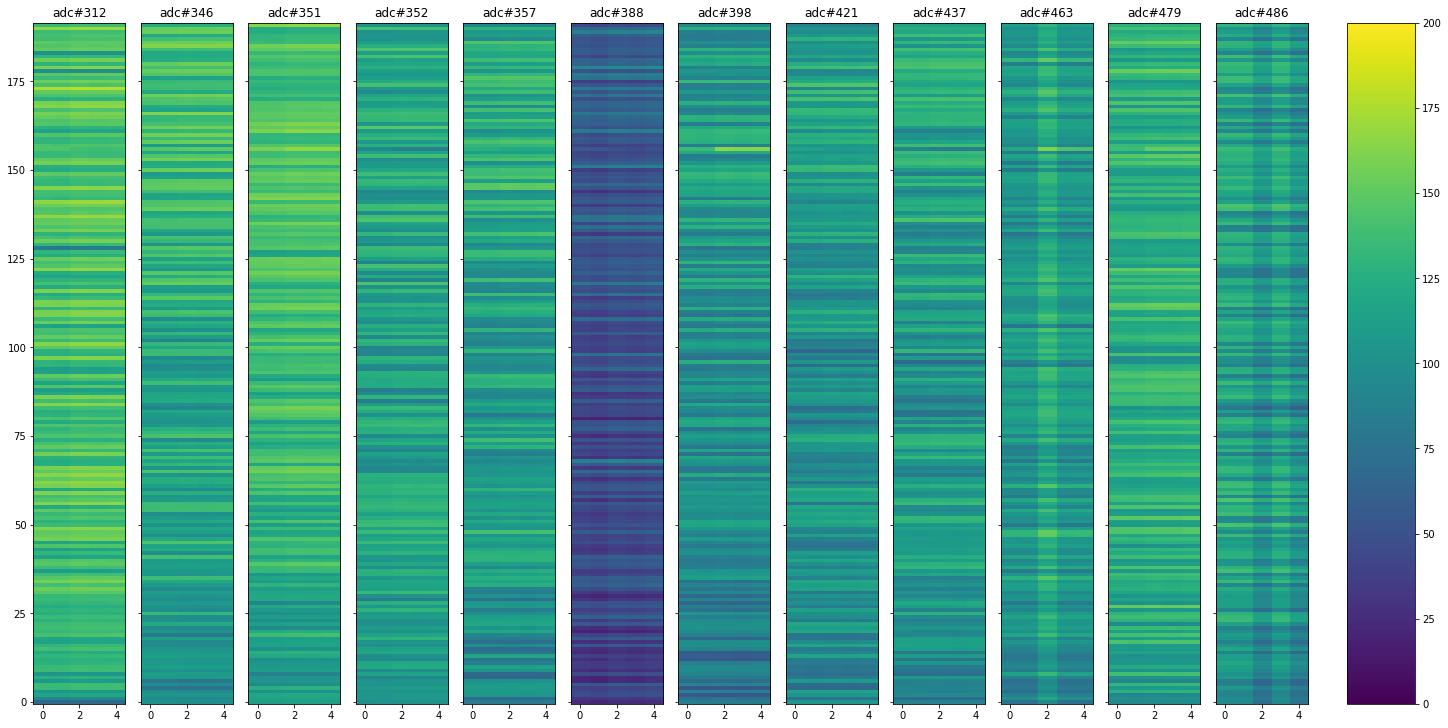

In [153]:
fig, axes = plt.subplots(1, len(adcs),figsize=(20,10),constrained_layout=True, sharey=True)

for i, adc in enumerate(adcs):    
    print peds_slice[adc].shape, np.min(peds_slice[adc]), np.max(peds_slice[adc])
    
    im=axes[i].imshow(np.transpose(peds_slice[adc]), vmin=0, vmax=200, interpolation="none",origin="lower", aspect="auto")
    
    axes[i].set_title('adc#%s'%adc)

fig.colorbar(im,ax=axes.ravel())

(5, 192) 192
(5, 192) 192
(5, 192) 192
(5, 192) 192
(5, 192) 192
(5, 192) 192
(5, 192) 192
(5, 192) 192
(5, 192) 192
(5, 192) 192
(5, 192) 192
(5, 192) 192


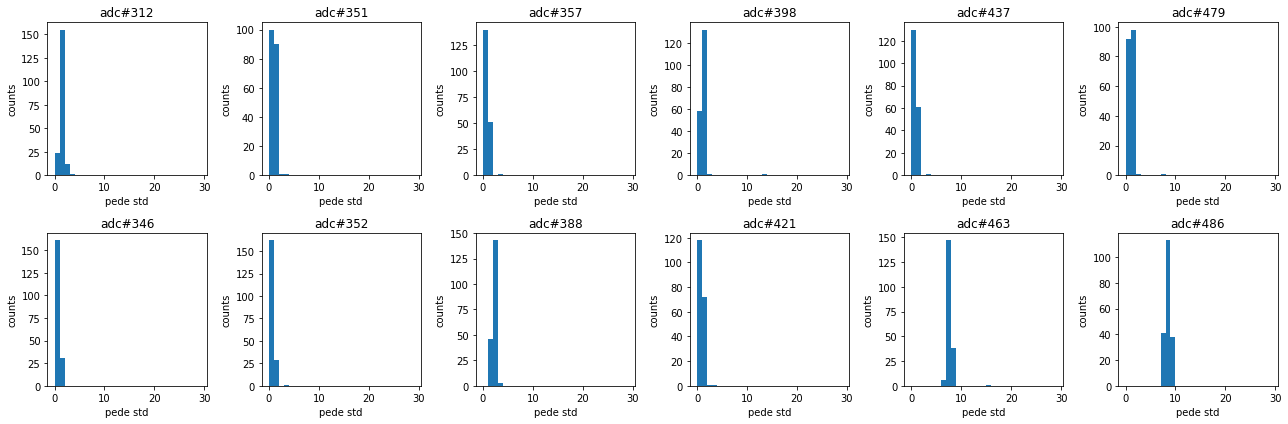

In [154]:
fig, axes = plt.subplots(2, int(len(adcs)/2),figsize=(18,6),tight_layout=True)

for i, adc in enumerate(adcs):    
    print peds_slice[adc].shape, len(np.std(peds_slice[adc], axis=0))
    #print peds_slice[adc][:,1], np.std(peds_slice[adc], axis=0)[1]
    
    axes[i%2,i/2].hist(np.std(peds_slice[adc],axis=0), bins=range(0,30))
    axes[i%2,i/2].set_xlabel('pede std')
    axes[i%2,i/2].set_ylabel('counts')
    axes[i%2,i/2].set_title('adc#%s'%adc)

Text(0.5,1,'H2052 run1860 electrical')

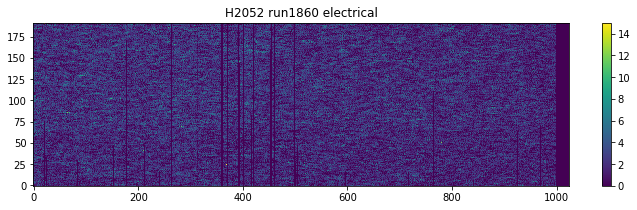

In [190]:
## hitmap plot from OnlineMonitor 
## but the masked pixels are not shown in pv

hitmap = get_pv('PXD:X%s:hitmap:MAP:cur'%dhe[1:]).get()

hitmap = hitmap.reshape(768, 256)

matrix_dcd = mapping.matrixToDcd(hitmap)
#print np.where(np.mean(matrix_dcd, axis=0)>13*192)
#print np.transpose(np.where(hitmap>14))

fig, axes = plt.subplots(figsize=(12,3))
im = axes.imshow(matrix_dcd, interpolation="none",origin="lower", aspect="auto", vmin=0,vmax=15)
cbar = plt.colorbar(im)

axes.set_title('%s run%s electrical'%(dhe, runnr))
#axes.set_xlim(256,512)